# Customer Churn Prediction for E-Commerce

## Identifying At-Risk Customers Using Transaction Data

---

**Author:** Jamiu Olamilekan Badmus  
**Email:** jamiubadmus001@gmail.com  
**LinkedIn:** [Jamiu Olamilekan Badmus](https://www.linkedin.com/in/jamiu-olamilekan-badmus-9276a8192/)  
**GitHub:** [jamiubadmusng](https://github.com/jamiubadmusng)

---

## Table of Contents

1. [Introduction](#1-introduction)
2. [Data Loading and Exploration](#2-data-loading-and-exploration)
3. [Data Cleaning](#3-data-cleaning)
4. [Exploratory Data Analysis](#4-exploratory-data-analysis)
5. [Feature Engineering - RFM Analysis](#5-feature-engineering---rfm-analysis)
6. [Churn Definition and Labeling](#6-churn-definition-and-labeling)
7. [Advanced Feature Engineering](#7-advanced-feature-engineering)
8. [Data Preprocessing](#8-data-preprocessing)
9. [Model Training and Evaluation](#9-model-training-and-evaluation)
10. [Model Interpretation with SHAP](#10-model-interpretation-with-shap)
11. [Business Recommendations](#11-business-recommendations)
12. [Conclusions](#12-conclusions)

---

## 1. Introduction

### Business Context

Customer churn (customer attrition) is one of the biggest challenges for e-commerce businesses. Studies show that:

- **Acquiring a new customer costs 5-25x more** than retaining an existing one
- **Increasing customer retention by 5%** can increase profits by 25-95%
- The probability of selling to an existing customer is 60-70%, vs. 5-20% for new prospects

### Project Objectives

1. **Define churn** in a non-contractual e-commerce setting (no explicit cancellation)
2. **Engineer predictive features** from transaction data using RFM and behavioral metrics
3. **Build machine learning models** to identify customers at risk of churning
4. **Provide actionable insights** for customer retention strategies

### Dataset

We use the **Online Retail Dataset** from the UCI Machine Learning Repository, containing:
- All transactions for a UK-based online retailer (2010-2011)
- ~541,000 transaction records
- 4,300+ unique customers with CustomerID
- Products: Mainly unique all-occasion gifts

## 2. Data Loading and Exploration

### 2.1 Import Libraries

In [1]:
# Core libraries
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    precision_recall_curve, roc_curve, f1_score, accuracy_score,
    precision_score, recall_score, average_precision_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Model Interpretation
import shap

# Utilities
import joblib
from datetime import datetime, timedelta

# Display settings
pd.set_option('display.max_columns', 50)
pd.set_option('display.float_format', '{:.2f}'.format)
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

print("Libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

Libraries imported successfully!
Pandas version: 3.0.0
NumPy version: 2.3.5


### 2.2 Load Dataset

In [2]:
# Define data path
DATA_PATH = '../data/raw/online_retail.csv'

# Load data
df = pd.read_csv(DATA_PATH)

print(f"Dataset loaded: {df.shape[0]:,} transactions, {df.shape[1]} columns")
print(f"\nColumns: {list(df.columns)}")

Dataset loaded: 541,909 transactions, 8 columns

Columns: ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']


In [3]:
# First look at the data
df.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.00,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.00,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.00,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.00,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.00,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,12/1/2010 8:26,7.65,17850.00,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,12/1/2010 8:26,4.25,17850.00,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,12/1/2010 8:28,1.85,17850.00,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,12/1/2010 8:28,1.85,17850.00,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,12/1/2010 8:34,1.69,13047.00,United Kingdom


In [4]:
# Data types and info
print("Data Types:")
print(df.dtypes)
print(f"\nMemory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

Data Types:
InvoiceNo          str
StockCode          str
Description        str
Quantity         int64
InvoiceDate        str
UnitPrice      float64
CustomerID     float64
Country            str
dtype: object

Memory Usage: 173.12 MB


In [5]:
# Statistical summary
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.00,541909.00,406829.00
mean,9.55,4.61,15287.69
std,218.08,96.76,1713.60
min,-80995.00,-11062.06,12346.00
25%,1.00,1.25,13953.00
50%,3.00,2.08,15152.00
75%,10.00,4.13,16791.00
max,80995.00,38970.00,18287.00


### 2.3 Missing Values Analysis

In [6]:
# Check missing values
missing = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(2)

missing_df = pd.DataFrame({
    'Column': missing.index,
    'Missing Count': missing.values,
    'Missing %': missing_pct.values
}).sort_values('Missing Count', ascending=False)

print("Missing Values Summary:")
print(missing_df.to_string(index=False))

Missing Values Summary:
     Column  Missing Count  Missing %
 CustomerID         135080      24.93
Description           1454       0.27
  StockCode              0       0.00
  InvoiceNo              0       0.00
   Quantity              0       0.00
InvoiceDate              0       0.00
  UnitPrice              0       0.00
    Country              0       0.00


## 3. Data Cleaning

In [7]:
# Create a copy for cleaning
df_clean = df.copy()

# Convert InvoiceDate to datetime
df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'])

print(f"Original dataset: {len(df):,} rows")

# Remove rows without CustomerID (we need this for churn analysis)
df_clean = df_clean[df_clean['CustomerID'].notna()]
print(f"After removing null CustomerID: {len(df_clean):,} rows")

# Remove cancelled orders (InvoiceNo starts with 'C')
df_clean['IsCancelled'] = df_clean['InvoiceNo'].astype(str).str.startswith('C')
print(f"Cancelled orders: {df_clean['IsCancelled'].sum():,} ({df_clean['IsCancelled'].mean()*100:.2f}%)")

# Keep cancellation info for feature engineering, but filter for main analysis
df_orders = df_clean[~df_clean['IsCancelled']].copy()
print(f"After removing cancelled orders: {len(df_orders):,} rows")

# Remove zero or negative quantities and prices
df_orders = df_orders[(df_orders['Quantity'] > 0) & (df_orders['UnitPrice'] > 0)]
print(f"After removing invalid quantities/prices: {len(df_orders):,} rows")

# Calculate total amount for each line item
df_orders['TotalAmount'] = df_orders['Quantity'] * df_orders['UnitPrice']

print(f"\nFinal cleaned dataset: {len(df_orders):,} transactions")
print(f"Unique customers: {df_orders['CustomerID'].nunique():,}")
print(f"Date range: {df_orders['InvoiceDate'].min()} to {df_orders['InvoiceDate'].max()}")

Original dataset: 541,909 rows
After removing null CustomerID: 406,829 rows
Cancelled orders: 8,905 (2.19%)
After removing cancelled orders: 397,924 rows
After removing invalid quantities/prices: 397,884 rows

Final cleaned dataset: 397,884 transactions
Unique customers: 4,338
Date range: 2010-12-01 08:26:00 to 2011-12-09 12:50:00


## 4. Exploratory Data Analysis

### 4.1 Time-based Analysis

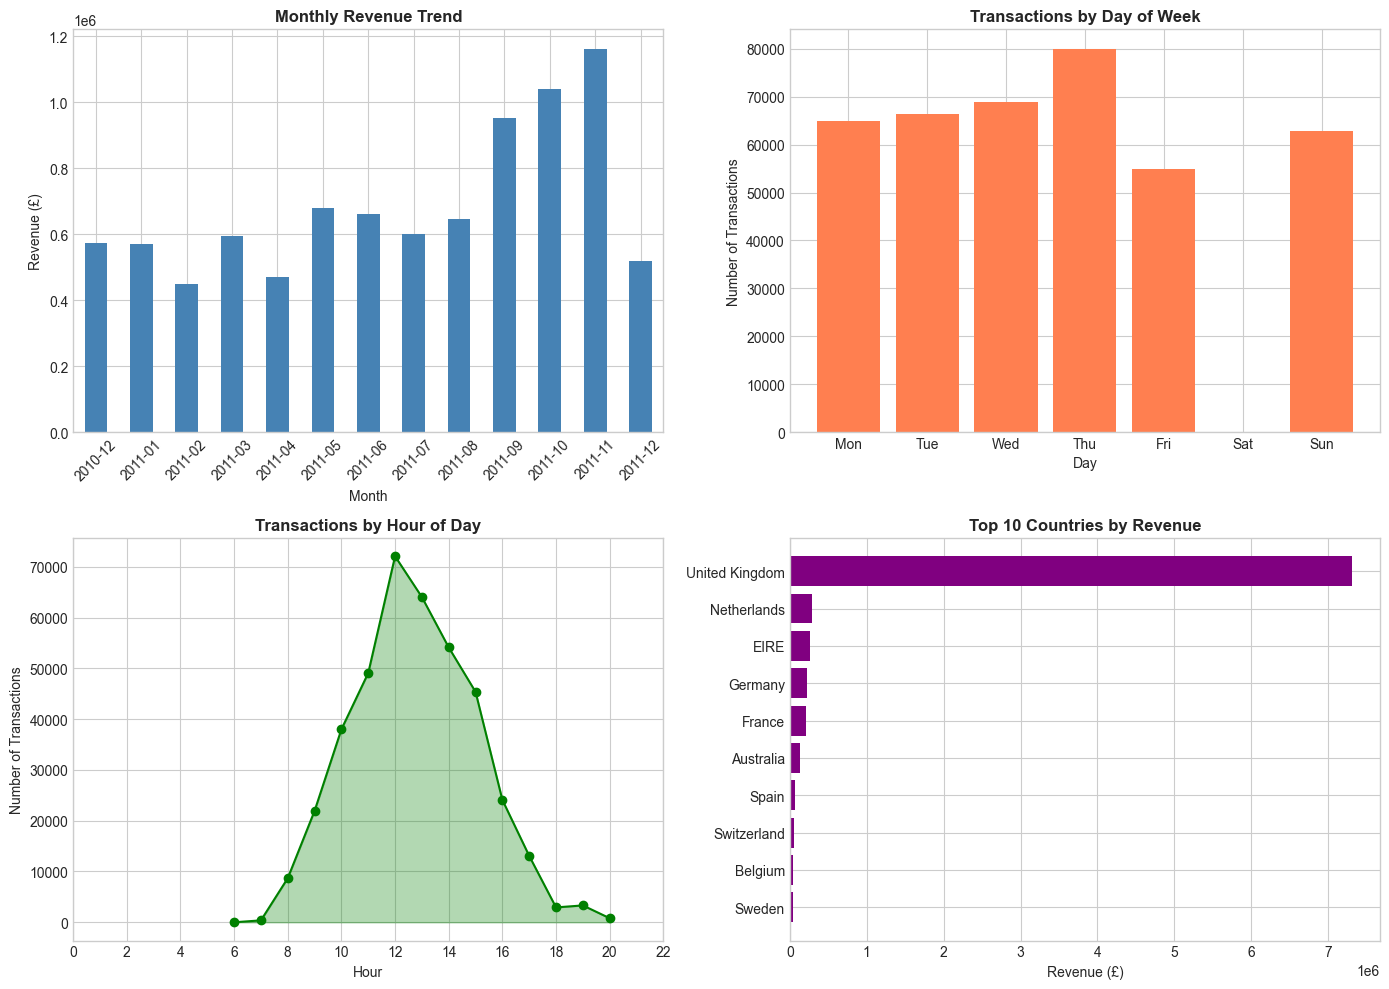

In [9]:
# Extract time features
df_orders['Year'] = df_orders['InvoiceDate'].dt.year
df_orders['Month'] = df_orders['InvoiceDate'].dt.month
df_orders['DayOfWeek'] = df_orders['InvoiceDate'].dt.dayofweek
df_orders['Hour'] = df_orders['InvoiceDate'].dt.hour

# Monthly revenue trend
monthly_revenue = df_orders.groupby([df_orders['InvoiceDate'].dt.to_period('M')])['TotalAmount'].sum()

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Monthly revenue
ax1 = axes[0, 0]
monthly_revenue.plot(kind='bar', ax=ax1, color='steelblue')
ax1.set_title('Monthly Revenue Trend', fontsize=12, fontweight='bold')
ax1.set_xlabel('Month')
ax1.set_ylabel('Revenue (£)')
ax1.tick_params(axis='x', rotation=45)

# Transactions by day of week
ax2 = axes[0, 1]
day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
daily_orders = df_orders.groupby('DayOfWeek').size().reindex(range(7), fill_value=0)
ax2.bar(day_names, daily_orders.values, color='coral')
ax2.set_title('Transactions by Day of Week', fontsize=12, fontweight='bold')
ax2.set_xlabel('Day')
ax2.set_ylabel('Number of Transactions')

# Transactions by hour
ax3 = axes[1, 0]
hourly_orders = df_orders.groupby('Hour').size()
ax3.plot(hourly_orders.index, hourly_orders.values, marker='o', color='green')
ax3.fill_between(hourly_orders.index, hourly_orders.values, alpha=0.3, color='green')
ax3.set_title('Transactions by Hour of Day', fontsize=12, fontweight='bold')
ax3.set_xlabel('Hour')
ax3.set_ylabel('Number of Transactions')
ax3.set_xticks(range(0, 24, 2))

# Revenue by country (top 10)
ax4 = axes[1, 1]
country_revenue = df_orders.groupby('Country')['TotalAmount'].sum().sort_values(ascending=True).tail(10)
ax4.barh(country_revenue.index, country_revenue.values, color='purple')
ax4.set_title('Top 10 Countries by Revenue', fontsize=12, fontweight='bold')
ax4.set_xlabel('Revenue (£)')

plt.tight_layout()
plt.savefig('../docs/figures/temporal_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

### 4.2 Customer Distribution Analysis

In [10]:
# Customer-level aggregations
customer_stats = df_orders.groupby('CustomerID').agg({
    'InvoiceNo': 'nunique',
    'TotalAmount': 'sum',
    'Quantity': 'sum',
    'InvoiceDate': ['min', 'max']
}).reset_index()

customer_stats.columns = ['CustomerID', 'TotalOrders', 'TotalSpend', 'TotalItems', 'FirstPurchase', 'LastPurchase']
customer_stats['AvgOrderValue'] = customer_stats['TotalSpend'] / customer_stats['TotalOrders']
customer_stats['CustomerTenure'] = (customer_stats['LastPurchase'] - customer_stats['FirstPurchase']).dt.days

print(f"Customer Statistics Summary:")
print(customer_stats.describe())

Customer Statistics Summary:
       CustomerID  TotalOrders  TotalSpend  TotalItems  \
count     4338.00      4338.00     4338.00     4338.00   
mean     15300.41         4.27     2054.27     1191.29   
min      12346.00         1.00        3.75        1.00   
25%      13813.25         1.00      307.41      160.00   
50%      15299.50         2.00      674.49      379.00   
75%      16778.75         5.00     1661.74      992.75   
max      18287.00       209.00   280206.02   196915.00   
std       1721.81         7.70     8989.23     5046.08   

                    FirstPurchase                LastPurchase  AvgOrderValue  \
count                        4338                        4338        4338.00   
mean   2011-04-30 17:06:50.857538  2011-09-08 11:38:59.045643         419.17   
min           2010-12-01 08:26:00         2010-12-01 09:53:00           3.45   
25%           2011-01-17 11:13:15         2011-07-20 19:18:00         178.62   
50%           2011-04-05 09:52:30         2011-1

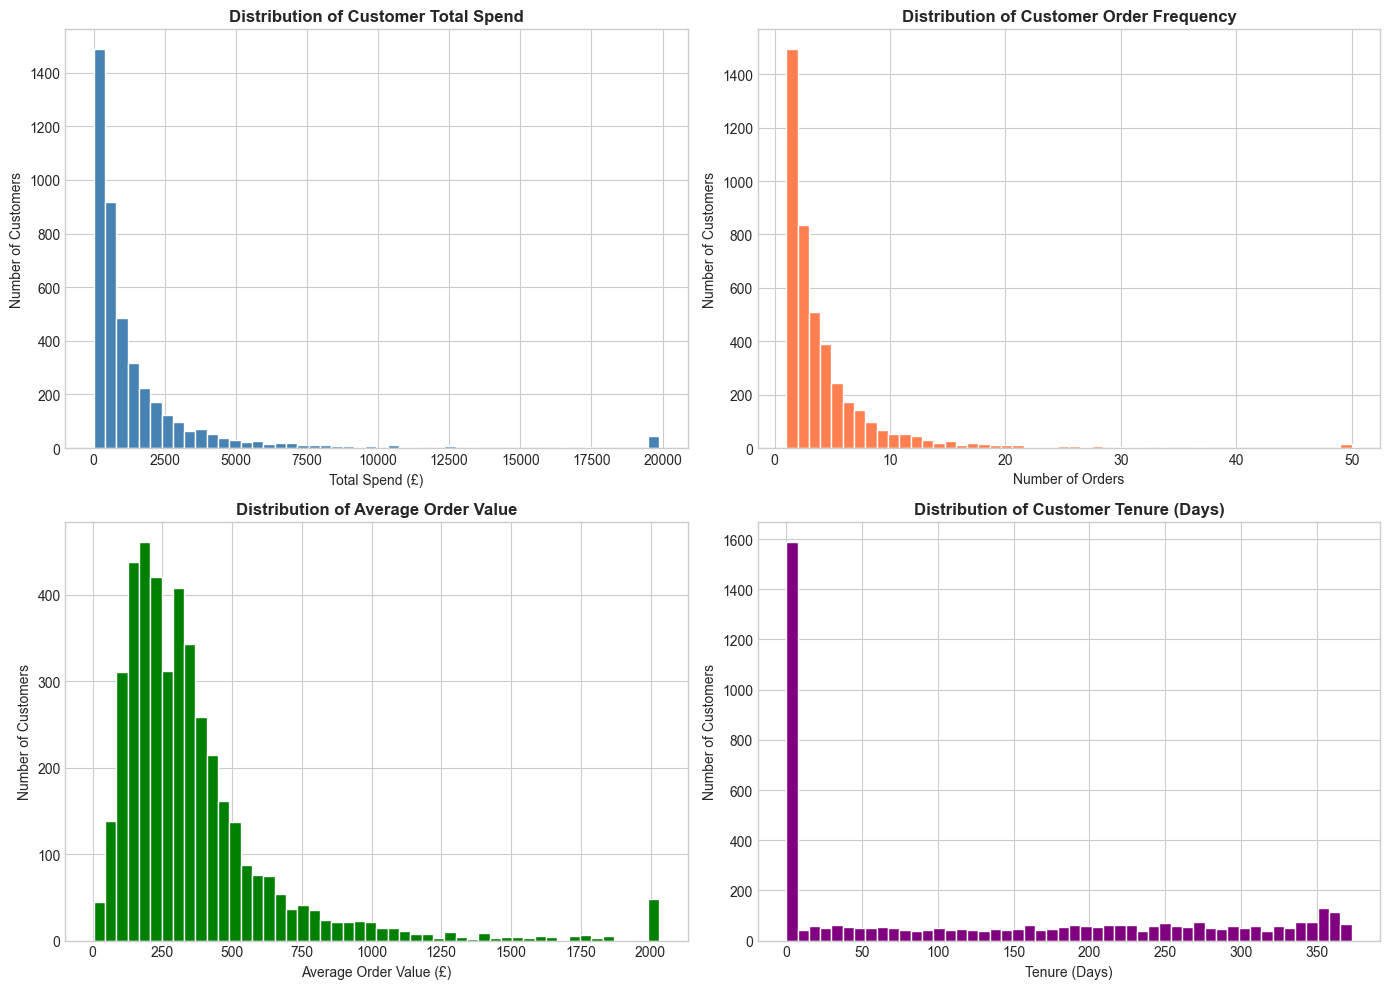

In [11]:
# Customer distribution visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Total spend distribution (log scale)
ax1 = axes[0, 0]
customer_stats['TotalSpend'].clip(upper=customer_stats['TotalSpend'].quantile(0.99)).hist(bins=50, ax=ax1, color='steelblue', edgecolor='white')
ax1.set_title('Distribution of Customer Total Spend', fontsize=12, fontweight='bold')
ax1.set_xlabel('Total Spend (£)')
ax1.set_ylabel('Number of Customers')

# Number of orders distribution
ax2 = axes[0, 1]
customer_stats['TotalOrders'].clip(upper=50).hist(bins=50, ax=ax2, color='coral', edgecolor='white')
ax2.set_title('Distribution of Customer Order Frequency', fontsize=12, fontweight='bold')
ax2.set_xlabel('Number of Orders')
ax2.set_ylabel('Number of Customers')

# Average order value
ax3 = axes[1, 0]
customer_stats['AvgOrderValue'].clip(upper=customer_stats['AvgOrderValue'].quantile(0.99)).hist(bins=50, ax=ax3, color='green', edgecolor='white')
ax3.set_title('Distribution of Average Order Value', fontsize=12, fontweight='bold')
ax3.set_xlabel('Average Order Value (£)')
ax3.set_ylabel('Number of Customers')

# Customer tenure
ax4 = axes[1, 1]
customer_stats['CustomerTenure'].hist(bins=50, ax=ax4, color='purple', edgecolor='white')
ax4.set_title('Distribution of Customer Tenure (Days)', fontsize=12, fontweight='bold')
ax4.set_xlabel('Tenure (Days)')
ax4.set_ylabel('Number of Customers')

plt.tight_layout()
plt.savefig('../docs/figures/customer_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

### 4.3 Product Analysis

In [12]:
# Top products by revenue
product_revenue = df_orders.groupby(['StockCode', 'Description']).agg({
    'TotalAmount': 'sum',
    'Quantity': 'sum',
    'InvoiceNo': 'nunique'
}).reset_index()

product_revenue.columns = ['StockCode', 'Description', 'Revenue', 'QuantitySold', 'OrderCount']
product_revenue = product_revenue.sort_values('Revenue', ascending=False)

print("Top 15 Products by Revenue:")
print(product_revenue.head(15).to_string(index=False))

Top 15 Products by Revenue:
StockCode                        Description   Revenue  QuantitySold  OrderCount
    23843        PAPER CRAFT , LITTLE BIRDIE 168469.60         80995           1
    22423           REGENCY CAKESTAND 3 TIER 142592.95         12402        1703
   85123A WHITE HANGING HEART T-LIGHT HOLDER 100448.15         36725        1971
   85099B            JUMBO BAG RED RETROSPOT  85220.78         46181        1600
    23166     MEDIUM CERAMIC TOP STORAGE JAR  81416.73         77916         195
     POST                            POSTAGE  77803.96          3120        1099
    47566                      PARTY BUNTING  68844.33         15291        1379
    84879      ASSORTED COLOUR BIRD ORNAMENT  56580.34         35362        1375
        M                             Manual  53779.93          7173         253
    23084                 RABBIT NIGHT LIGHT  51346.20         27202         801
    79321                      CHILLI LIGHTS  46286.51          9650         519


## 5. Feature Engineering - RFM Analysis

RFM (Recency, Frequency, Monetary) is a marketing analysis technique used to identify best customers.

- **Recency**: How recently did the customer make a purchase?
- **Frequency**: How often do they purchase?
- **Monetary**: How much do they spend?

In [13]:
# Define the analysis date (one day after the last transaction)
analysis_date = df_orders['InvoiceDate'].max() + timedelta(days=1)
print(f"Analysis reference date: {analysis_date}")

# Calculate RFM metrics for each customer
rfm = df_orders.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (analysis_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',  # Frequency
    'TotalAmount': 'sum'  # Monetary
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

print(f"\nRFM Summary Statistics:")
print(rfm.describe())

Analysis reference date: 2011-12-10 12:50:00

RFM Summary Statistics:
       CustomerID  Recency  Frequency  Monetary
count     4338.00  4338.00    4338.00   4338.00
mean     15300.41    92.54       4.27   2054.27
std       1721.81   100.01       7.70   8989.23
min      12346.00     1.00       1.00      3.75
25%      13813.25    18.00       1.00    307.41
50%      15299.50    51.00       2.00    674.49
75%      16778.75   142.00       5.00   1661.74
max      18287.00   374.00     209.00 280206.02


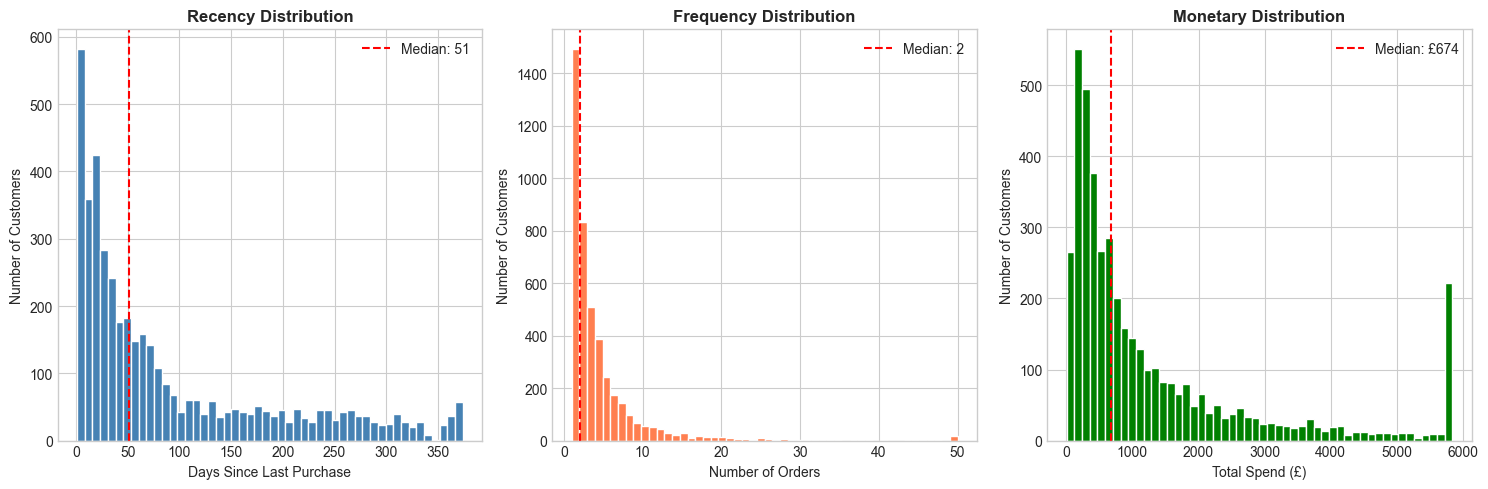

In [14]:
# RFM distributions
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Recency
axes[0].hist(rfm['Recency'], bins=50, color='steelblue', edgecolor='white')
axes[0].set_title('Recency Distribution', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Days Since Last Purchase')
axes[0].set_ylabel('Number of Customers')
axes[0].axvline(rfm['Recency'].median(), color='red', linestyle='--', label=f'Median: {rfm["Recency"].median():.0f}')
axes[0].legend()

# Frequency
axes[1].hist(rfm['Frequency'].clip(upper=50), bins=50, color='coral', edgecolor='white')
axes[1].set_title('Frequency Distribution', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Number of Orders')
axes[1].set_ylabel('Number of Customers')
axes[1].axvline(rfm['Frequency'].median(), color='red', linestyle='--', label=f'Median: {rfm["Frequency"].median():.0f}')
axes[1].legend()

# Monetary
axes[2].hist(rfm['Monetary'].clip(upper=rfm['Monetary'].quantile(0.95)), bins=50, color='green', edgecolor='white')
axes[2].set_title('Monetary Distribution', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Total Spend (£)')
axes[2].set_ylabel('Number of Customers')
axes[2].axvline(rfm['Monetary'].median(), color='red', linestyle='--', label=f'Median: £{rfm["Monetary"].median():.0f}')
axes[2].legend()

plt.tight_layout()
plt.savefig('../docs/figures/rfm_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Churn Definition and Labeling

In a non-contractual setting (like e-commerce), churn isn't explicit. We define a customer as **churned** if they haven't made a purchase in a defined period.

**Approach:**
1. Split data into two periods: Feature Period (first 9 months) and Outcome Period (last 3 months)
2. A customer churns if they were active in Feature Period but inactive in Outcome Period

In [15]:
# Define the time split
data_end = df_orders['InvoiceDate'].max()
data_start = df_orders['InvoiceDate'].min()
total_days = (data_end - data_start).days

print(f"Data period: {data_start.date()} to {data_end.date()} ({total_days} days)")

# Split: Feature period (first ~9 months) | Outcome period (last ~3 months)
# We'll use 90 days as the outcome window
outcome_window = 90  # days
split_date = data_end - timedelta(days=outcome_window)

print(f"\nFeature period: {data_start.date()} to {split_date.date()}")
print(f"Outcome period: {split_date.date()} to {data_end.date()}")

Data period: 2010-12-01 to 2011-12-09 (373 days)

Feature period: 2010-12-01 to 2011-09-10
Outcome period: 2011-09-10 to 2011-12-09


In [16]:
# Identify customers active in each period
feature_period = df_orders[df_orders['InvoiceDate'] <= split_date]
outcome_period = df_orders[df_orders['InvoiceDate'] > split_date]

customers_feature = set(feature_period['CustomerID'].unique())
customers_outcome = set(outcome_period['CustomerID'].unique())

print(f"Customers in feature period: {len(customers_feature):,}")
print(f"Customers in outcome period: {len(customers_outcome):,}")

# Churned = Active in feature period but NOT in outcome period
churned_customers = customers_feature - customers_outcome
retained_customers = customers_feature & customers_outcome

print(f"\nChurned customers: {len(churned_customers):,}")
print(f"Retained customers: {len(retained_customers):,}")
print(f"Churn rate: {len(churned_customers) / len(customers_feature) * 100:.2f}%")

Customers in feature period: 3,370
Customers in outcome period: 2,889

Churned customers: 1,449
Retained customers: 1,921
Churn rate: 43.00%


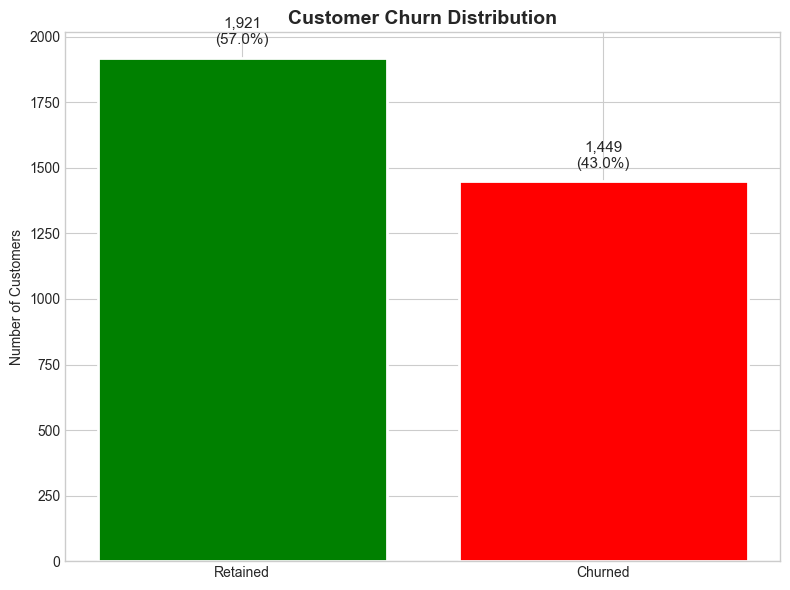

In [17]:
# Create churn labels
churn_labels = pd.DataFrame({'CustomerID': list(customers_feature)})
churn_labels['Churned'] = churn_labels['CustomerID'].apply(
    lambda x: 1 if x in churned_customers else 0
)

# Visualize churn distribution
fig, ax = plt.subplots(figsize=(8, 6))
churn_counts = churn_labels['Churned'].value_counts()
colors = ['green', 'red']
labels = ['Retained', 'Churned']

bars = ax.bar(labels, churn_counts.values, color=colors, edgecolor='white', linewidth=2)
ax.set_title('Customer Churn Distribution', fontsize=14, fontweight='bold')
ax.set_ylabel('Number of Customers')

# Add value labels
for bar, count in zip(bars, churn_counts.values):
    pct = count / len(churn_labels) * 100
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50, 
            f'{count:,}\n({pct:.1f}%)', ha='center', fontsize=11)

plt.tight_layout()
plt.savefig('../docs/figures/churn_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Advanced Feature Engineering

We'll create features from the **feature period only** to ensure no data leakage.

In [18]:
# Work with feature period data only
df_feature = feature_period.copy()

# Reference date for feature period
feature_ref_date = split_date + timedelta(days=1)

print(f"Building features from {df_feature['InvoiceDate'].min().date()} to {df_feature['InvoiceDate'].max().date()}")
print(f"Reference date for recency: {feature_ref_date.date()}")

Building features from 2010-12-01 to 2011-09-09
Reference date for recency: 2011-09-11


In [19]:
# Calculate comprehensive customer features

# Basic RFM
customer_features = df_feature.groupby('CustomerID').agg({
    'InvoiceDate': [
        lambda x: (feature_ref_date - x.max()).days,  # Recency
        lambda x: (feature_ref_date - x.min()).days,  # Tenure (days since first purchase)
    ],
    'InvoiceNo': 'nunique',  # Frequency (number of orders)
    'TotalAmount': ['sum', 'mean', 'std', 'max'],  # Monetary metrics
    'Quantity': ['sum', 'mean'],  # Quantity metrics
    'UnitPrice': ['mean', 'std'],  # Price point preference
    'StockCode': 'nunique',  # Product diversity
}).reset_index()

# Flatten column names
customer_features.columns = [
    'CustomerID', 'Recency', 'Tenure', 'Frequency', 
    'TotalSpend', 'AvgOrderValue', 'StdOrderValue', 'MaxOrderValue',
    'TotalQuantity', 'AvgQuantityPerOrder',
    'AvgUnitPrice', 'StdUnitPrice',
    'UniqueProducts'
]

# Fill NaN standard deviations (for customers with single order)
customer_features['StdOrderValue'] = customer_features['StdOrderValue'].fillna(0)
customer_features['StdUnitPrice'] = customer_features['StdUnitPrice'].fillna(0)

print(f"Basic features created for {len(customer_features):,} customers")

Basic features created for 3,370 customers


In [20]:
# Additional behavioral features

# Calculate purchase intervals
def calc_purchase_intervals(group):
    dates = group['InvoiceDate'].sort_values()
    if len(dates) < 2:
        return pd.Series({'AvgDaysBetweenPurchases': 0, 'StdDaysBetweenPurchases': 0})
    intervals = dates.diff().dt.days.dropna()
    return pd.Series({
        'AvgDaysBetweenPurchases': intervals.mean(),
        'StdDaysBetweenPurchases': intervals.std() if len(intervals) > 1 else 0
    })

interval_features = df_feature.groupby('CustomerID').apply(calc_purchase_intervals).reset_index()
interval_features['StdDaysBetweenPurchases'] = interval_features['StdDaysBetweenPurchases'].fillna(0)

customer_features = customer_features.merge(interval_features, on='CustomerID', how='left')

print("Purchase interval features added")

Purchase interval features added


In [21]:
# Time-based features

# Preferred shopping day and hour
df_feature['DayOfWeek'] = df_feature['InvoiceDate'].dt.dayofweek
df_feature['Hour'] = df_feature['InvoiceDate'].dt.hour

time_features = df_feature.groupby('CustomerID').agg({
    'DayOfWeek': lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else 0,
    'Hour': lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else 12,
}).reset_index()

time_features.columns = ['CustomerID', 'PreferredDay', 'PreferredHour']

customer_features = customer_features.merge(time_features, on='CustomerID', how='left')

print("Time preference features added")

Time preference features added


In [22]:
# Cancellation and return behavior (from full cleaned data before cancellation removal)
cancel_features = df_clean[df_clean['CustomerID'].isin(customers_feature)].groupby('CustomerID').agg({
    'IsCancelled': ['sum', 'mean']
}).reset_index()

cancel_features.columns = ['CustomerID', 'TotalCancellations', 'CancellationRate']

customer_features = customer_features.merge(cancel_features, on='CustomerID', how='left')
customer_features['TotalCancellations'] = customer_features['TotalCancellations'].fillna(0)
customer_features['CancellationRate'] = customer_features['CancellationRate'].fillna(0)

print("Cancellation features added")

Cancellation features added


In [23]:
# Geographic feature
country_features = df_feature.groupby('CustomerID')['Country'].agg(
    lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else 'Unknown'
).reset_index()
country_features.columns = ['CustomerID', 'Country']

# Is UK customer (majority of transactions)
customer_features = customer_features.merge(country_features, on='CustomerID', how='left')
customer_features['IsUK'] = (customer_features['Country'] == 'United Kingdom').astype(int)

print("Geographic features added")

Geographic features added


In [24]:
# Derived ratio features
customer_features['ItemsPerOrder'] = customer_features['TotalQuantity'] / customer_features['Frequency']
customer_features['SpendPerItem'] = customer_features['TotalSpend'] / customer_features['TotalQuantity']
customer_features['OrdersPerMonth'] = customer_features['Frequency'] / (customer_features['Tenure'] / 30 + 1)
customer_features['ProductDiversityRatio'] = customer_features['UniqueProducts'] / customer_features['TotalQuantity']

# Recency to frequency ratio (engagement pattern)
customer_features['RecencyFrequencyRatio'] = customer_features['Recency'] / (customer_features['Frequency'] + 1)

print("Derived ratio features added")

Derived ratio features added


In [25]:
# Merge with churn labels
df_final = customer_features.merge(churn_labels, on='CustomerID', how='inner')

print(f"\nFinal dataset shape: {df_final.shape}")
print(f"\nFeatures created:")
print(df_final.columns.tolist())


Final dataset shape: (3370, 27)

Features created:
['CustomerID', 'Recency', 'Tenure', 'Frequency', 'TotalSpend', 'AvgOrderValue', 'StdOrderValue', 'MaxOrderValue', 'TotalQuantity', 'AvgQuantityPerOrder', 'AvgUnitPrice', 'StdUnitPrice', 'UniqueProducts', 'AvgDaysBetweenPurchases', 'StdDaysBetweenPurchases', 'PreferredDay', 'PreferredHour', 'TotalCancellations', 'CancellationRate', 'Country', 'IsUK', 'ItemsPerOrder', 'SpendPerItem', 'OrdersPerMonth', 'ProductDiversityRatio', 'RecencyFrequencyRatio', 'Churned']


In [26]:
# Feature summary
df_final.describe()

,CustomerID,Recency,Tenure,Frequency,TotalSpend,AvgOrderValue,StdOrderValue,MaxOrderValue,TotalQuantity,AvgQuantityPerOrder,AvgUnitPrice,StdUnitPrice,UniqueProducts,AvgDaysBetweenPurchases,StdDaysBetweenPurchases,PreferredDay,PreferredHour,TotalCancellations,CancellationRate,IsUK,ItemsPerOrder,SpendPerItem,OrdersPerMonth,ProductDiversityRatio,RecencyFrequencyRatio,Churned
count,3370.00,3370.00,3370.00,3370.00,3370.00,3370.00,3370.00,3370.00,3370.00,3370.00,3370.00,3370.00,3370.00,3370.00,3370.00,3370.00,3370.00,3370.00,3370.00,3370.00,3370.00,3370.00,3370.00,3370.00,3370.00,3370.00
mean,15276.12,95.49,183.40,3.53,1618.81,61.63,29.98,150.78,952.35,44.65,4.24,4.48,49.93,2.58,8.32,2.55,12.48,2.43,0.03,0.90,241.72,2.69,0.48,0.13,39.00,0.43
std,1725.58,79.98,80.47,5.79,6151.39,1353.80,388.82,1517.72,3829.46,1283.52,15.37,20.21,67.55,9.38,11.99,1.80,2.34,8.08,0.06,0.30,1309.41,12.13,0.58,0.13,40.55,0.50
min,12346.00,1.00,1.00,1.00,2.90,1.45,0.00,1.65,1.00,1.00,0.11,0.00,1.00,0.00,0.00,0.00,7.00,0.00,0.00,0.00,1.00,0.08,0.10,0.00,0.01,0.00
25%,13786.25,26.00,124.00,1.00,266.10,12.71,5.72,30.86,132.00,5.93,2.27,1.77,14.00,0.00,0.00,1.00,11.00,0.00,0.00,1.00,84.00,1.45,0.20,0.06,6.00,0.00
50%,15234.50,75.00,194.00,2.00,565.96,17.83,9.45,51.00,314.00,9.74,3.02,2.66,29.00,0.71,4.89,3.00,12.00,0.00,0.00,1.00,149.54,1.87,0.34,0.09,22.67,0.00
75%,16765.75,152.00,265.00,4.00,1388.94,25.55,19.57,102.00,783.75,14.59,4.03,3.62,63.00,2.35,12.60,4.00,14.00,2.00,0.02,1.00,258.31,2.46,0.59,0.15,62.00,1.00
max,18287.00,284.00,284.00,132.00,178302.62,77183.60,22226.81,77183.60,127744.00,74215.00,451.42,602.44,1230.00,219.00,142.84,6.00,20.00,226.00,0.94,1.00,74215.00,451.42,12.61,1.00,142.00,1.00


### 7.1 Feature Analysis by Churn Status

In [27]:
# Compare key features between churned and retained customers
key_features = ['Recency', 'Frequency', 'TotalSpend', 'AvgOrderValue', 
                'UniqueProducts', 'AvgDaysBetweenPurchases', 'CancellationRate']

comparison = df_final.groupby('Churned')[key_features].mean().T
comparison.columns = ['Retained', 'Churned']
comparison['Difference'] = comparison['Churned'] - comparison['Retained']
comparison['% Difference'] = (comparison['Difference'] / comparison['Retained'] * 100).round(1)

print("Feature Comparison: Churned vs Retained Customers")
print("="*60)
print(comparison.to_string())

Feature Comparison: Churned vs Retained Customers
                         Retained  Churned  Difference  % Difference
Recency                     74.27   123.61       49.33         66.40
Frequency                    4.80     1.86       -2.94        -61.30
TotalSpend                2300.96   714.47    -1586.48        -68.90
AvgOrderValue               30.12   103.40       73.28        243.30
UniqueProducts              65.57    29.20      -36.37        -55.50
AvgDaysBetweenPurchases      2.64     2.51       -0.12         -4.70
CancellationRate             0.02     0.03        0.00         13.00


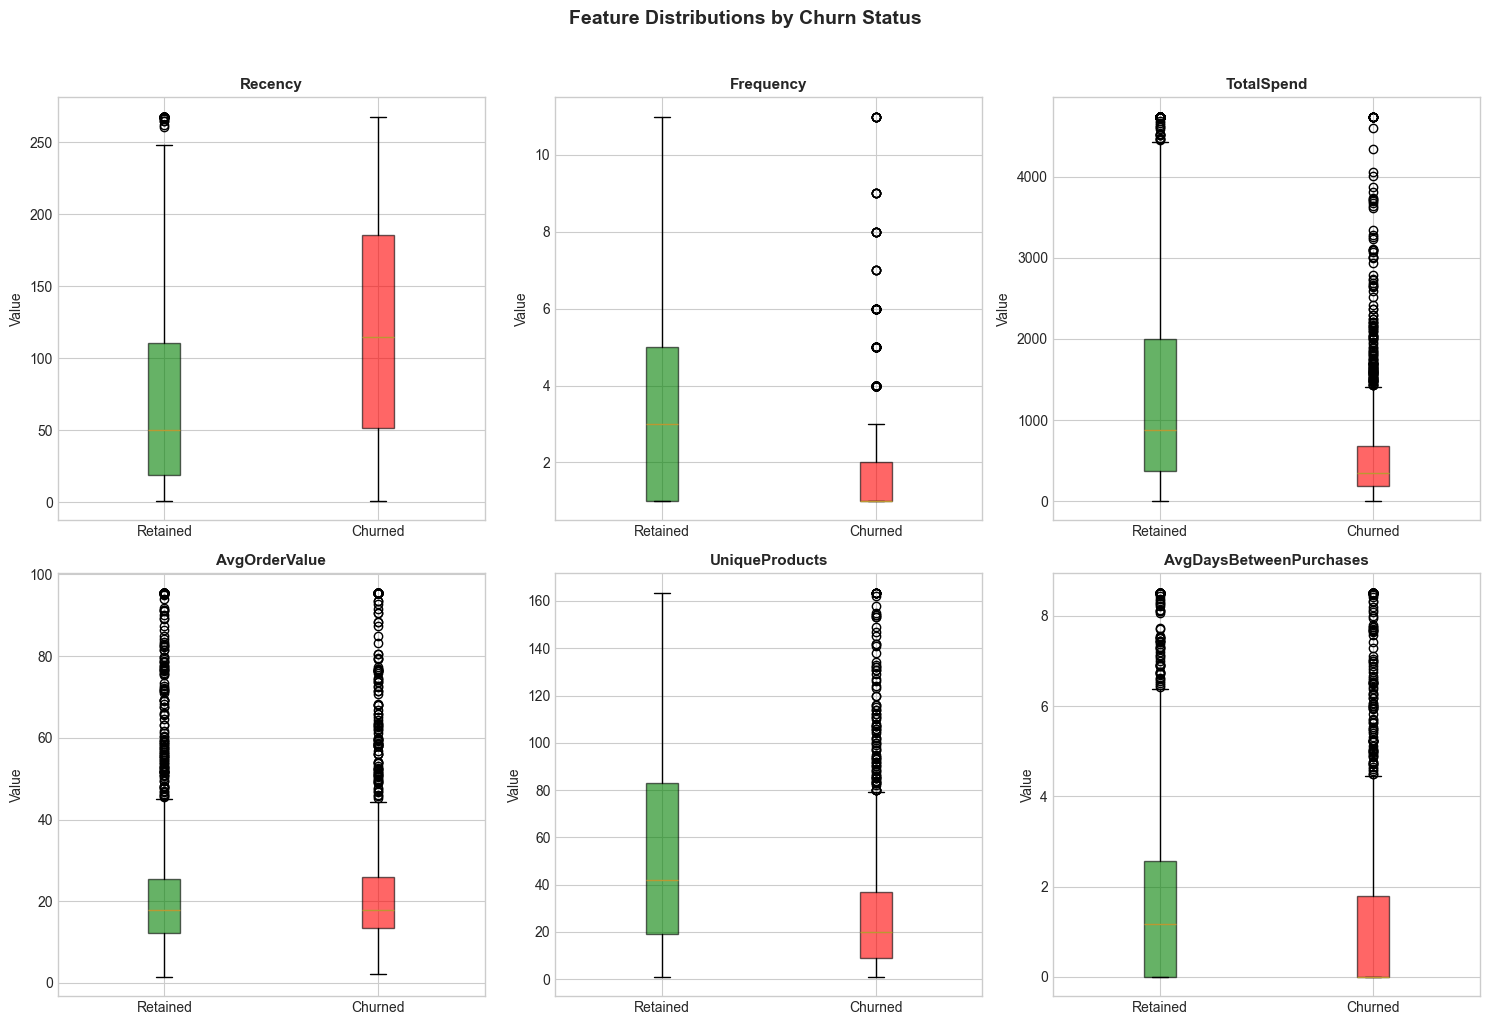

In [28]:
# Visualize feature differences
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

features_to_plot = ['Recency', 'Frequency', 'TotalSpend', 
                    'AvgOrderValue', 'UniqueProducts', 'AvgDaysBetweenPurchases']

for idx, feature in enumerate(features_to_plot):
    ax = axes[idx // 3, idx % 3]
    
    # Box plot
    retained_data = df_final[df_final['Churned'] == 0][feature]
    churned_data = df_final[df_final['Churned'] == 1][feature]
    
    # Clip outliers for visualization
    upper_limit = df_final[feature].quantile(0.95)
    
    box_data = [retained_data.clip(upper=upper_limit), churned_data.clip(upper=upper_limit)]
    bp = ax.boxplot(box_data, labels=['Retained', 'Churned'], patch_artist=True)
    
    bp['boxes'][0].set_facecolor('green')
    bp['boxes'][0].set_alpha(0.6)
    bp['boxes'][1].set_facecolor('red')
    bp['boxes'][1].set_alpha(0.6)
    
    ax.set_title(feature, fontsize=11, fontweight='bold')
    ax.set_ylabel('Value')

plt.suptitle('Feature Distributions by Churn Status', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../docs/figures/feature_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## 8. Data Preprocessing

In [29]:
# Prepare features for modeling
# Exclude non-feature columns
exclude_cols = ['CustomerID', 'Churned', 'Country']
feature_cols = [col for col in df_final.columns if col not in exclude_cols]

print(f"Features for modeling ({len(feature_cols)}):")
print(feature_cols)

Features for modeling (24):
['Recency', 'Tenure', 'Frequency', 'TotalSpend', 'AvgOrderValue', 'StdOrderValue', 'MaxOrderValue', 'TotalQuantity', 'AvgQuantityPerOrder', 'AvgUnitPrice', 'StdUnitPrice', 'UniqueProducts', 'AvgDaysBetweenPurchases', 'StdDaysBetweenPurchases', 'PreferredDay', 'PreferredHour', 'TotalCancellations', 'CancellationRate', 'IsUK', 'ItemsPerOrder', 'SpendPerItem', 'OrdersPerMonth', 'ProductDiversityRatio', 'RecencyFrequencyRatio']


In [30]:
# Check for infinite or missing values
X = df_final[feature_cols].copy()
y = df_final['Churned'].copy()

# Replace infinities with NaN, then fill with median
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.median())

print(f"Features shape: {X.shape}")
print(f"Target distribution:")
print(y.value_counts())
print(f"\nClass ratio: {y.value_counts()[1] / y.value_counts()[0]:.2f}:1")

Features shape: (3370, 24)
Target distribution:
Churned
0    1921
1    1449
Name: count, dtype: int64

Class ratio: 0.75:1


In [31]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]:,} samples")
print(f"Test set: {X_test.shape[0]:,} samples")
print(f"\nTraining churn rate: {y_train.mean()*100:.2f}%")
print(f"Test churn rate: {y_test.mean()*100:.2f}%")

Training set: 2,696 samples
Test set: 674 samples

Training churn rate: 42.99%
Test churn rate: 43.03%


In [32]:
# Scale features
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=feature_cols,
    index=X_train.index
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=feature_cols,
    index=X_test.index
)

print("Features scaled successfully")

Features scaled successfully


In [33]:
# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

print(f"Original training set: {len(y_train):,} ({y_train.sum():,} churned)")
print(f"After SMOTE: {len(y_train_resampled):,} ({y_train_resampled.sum():,} churned)")

Original training set: 2,696 (1,159 churned)
After SMOTE: 3,074 (1,537 churned)


## 9. Model Training and Evaluation

In [34]:
# Define models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42, max_depth=10),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100, max_depth=10, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42, n_estimators=100, max_depth=5),
    'XGBoost': XGBClassifier(random_state=42, n_estimators=100, max_depth=5, eval_metric='logloss', verbosity=0),
    'LightGBM': LGBMClassifier(random_state=42, n_estimators=100, max_depth=5, verbose=-1)
}

print(f"Models to evaluate: {list(models.keys())}")

Models to evaluate: ['Logistic Regression', 'Decision Tree', 'Random Forest', 'Gradient Boosting', 'XGBoost', 'LightGBM']


In [35]:
# Train and evaluate models with cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = {}

print("Training models with 5-fold cross-validation...")
print("="*70)

for name, model in models.items():
    # Cross-validation on resampled training data
    cv_scores = cross_val_score(model, X_train_resampled, y_train_resampled, 
                                 cv=cv, scoring='roc_auc', n_jobs=-1)
    
    # Train on full resampled training set
    model.fit(X_train_resampled, y_train_resampled)
    
    # Predict on test set
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    # Calculate metrics
    results[name] = {
        'CV ROC-AUC': cv_scores.mean(),
        'CV Std': cv_scores.std(),
        'Test ROC-AUC': roc_auc_score(y_test, y_pred_proba),
        'Test Accuracy': accuracy_score(y_test, y_pred),
        'Test Precision': precision_score(y_test, y_pred),
        'Test Recall': recall_score(y_test, y_pred),
        'Test F1': f1_score(y_test, y_pred)
    }
    
    print(f"{name}:")
    print(f"  CV ROC-AUC: {results[name]['CV ROC-AUC']:.4f} (+/- {results[name]['CV Std']:.4f})")
    print(f"  Test ROC-AUC: {results[name]['Test ROC-AUC']:.4f}, F1: {results[name]['Test F1']:.4f}")
    print()

Training models with 5-fold cross-validation...
Logistic Regression:
  CV ROC-AUC: 0.7682 (+/- 0.0276)
  Test ROC-AUC: 0.7362, F1: 0.6814

Decision Tree:
  CV ROC-AUC: 0.7155 (+/- 0.0147)
  Test ROC-AUC: 0.6449, F1: 0.6055

Random Forest:
  CV ROC-AUC: 0.8044 (+/- 0.0272)
  Test ROC-AUC: 0.7356, F1: 0.6498

Gradient Boosting:
  CV ROC-AUC: 0.8283 (+/- 0.0202)
  Test ROC-AUC: 0.7592, F1: 0.6836

XGBoost:
  CV ROC-AUC: 0.8286 (+/- 0.0190)
  Test ROC-AUC: 0.7473, F1: 0.6483

LightGBM:
  CV ROC-AUC: 0.8278 (+/- 0.0201)
  Test ROC-AUC: 0.7677, F1: 0.6844



In [36]:
# Create results dataframe
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values('Test ROC-AUC', ascending=False)

print("Model Performance Summary:")
print("="*80)
print(results_df.to_string())

Model Performance Summary:
                     CV ROC-AUC  CV Std  Test ROC-AUC  Test Accuracy  Test Precision  Test Recall  Test F1
LightGBM                   0.83    0.02          0.77           0.70            0.63         0.76     0.68
Gradient Boosting          0.83    0.02          0.76           0.70            0.63         0.74     0.68
XGBoost                    0.83    0.02          0.75           0.68            0.61         0.69     0.65
Logistic Regression        0.77    0.03          0.74           0.68            0.59         0.80     0.68
Random Forest              0.80    0.03          0.74           0.67            0.60         0.71     0.65
Decision Tree              0.72    0.01          0.64           0.64            0.57         0.65     0.61


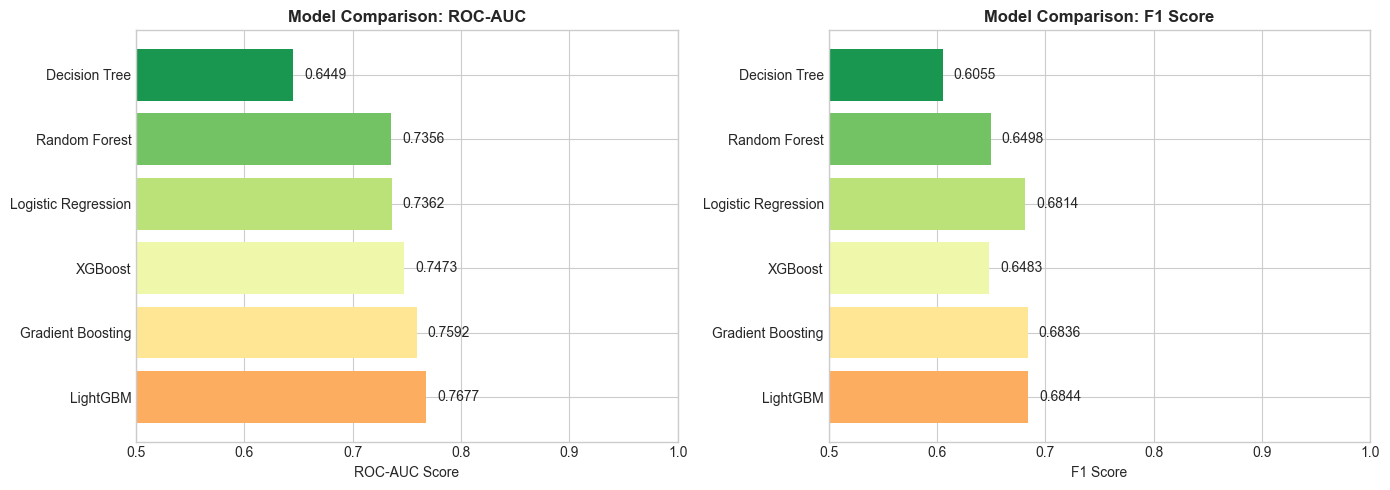

In [37]:
# Visualize model comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ROC-AUC comparison
ax1 = axes[0]
models_sorted = results_df.index.tolist()
roc_scores = results_df['Test ROC-AUC'].values
colors = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(models_sorted)))

bars = ax1.barh(models_sorted, roc_scores, color=colors)
ax1.set_xlabel('ROC-AUC Score')
ax1.set_title('Model Comparison: ROC-AUC', fontsize=12, fontweight='bold')
ax1.set_xlim(0.5, 1.0)

for bar, score in zip(bars, roc_scores):
    ax1.text(score + 0.01, bar.get_y() + bar.get_height()/2, 
             f'{score:.4f}', va='center', fontsize=10)

# F1 Score comparison
ax2 = axes[1]
f1_scores = results_df['Test F1'].values

bars = ax2.barh(models_sorted, f1_scores, color=colors)
ax2.set_xlabel('F1 Score')
ax2.set_title('Model Comparison: F1 Score', fontsize=12, fontweight='bold')
ax2.set_xlim(0.5, 1.0)

for bar, score in zip(bars, f1_scores):
    ax2.text(score + 0.01, bar.get_y() + bar.get_height()/2, 
             f'{score:.4f}', va='center', fontsize=10)

plt.tight_layout()
plt.savefig('../docs/figures/model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

In [38]:
# Select best model
best_model_name = results_df.index[0]
best_model = models[best_model_name]

print(f"Best Model: {best_model_name}")
print(f"Test ROC-AUC: {results_df.loc[best_model_name, 'Test ROC-AUC']:.4f}")

Best Model: LightGBM
Test ROC-AUC: 0.7677


### 9.1 Detailed Evaluation of Best Model

In [39]:
# Predictions with best model
y_pred_best = best_model.predict(X_test_scaled)
y_pred_proba_best = best_model.predict_proba(X_test_scaled)[:, 1]

# Classification report
print(f"Classification Report - {best_model_name}")
print("="*60)
print(classification_report(y_test, y_pred_best, target_names=['Retained', 'Churned']))

Classification Report - LightGBM
              precision    recall  f1-score   support

    Retained       0.78      0.66      0.71       384
     Churned       0.63      0.76      0.68       290

    accuracy                           0.70       674
   macro avg       0.70      0.71      0.70       674
weighted avg       0.71      0.70      0.70       674



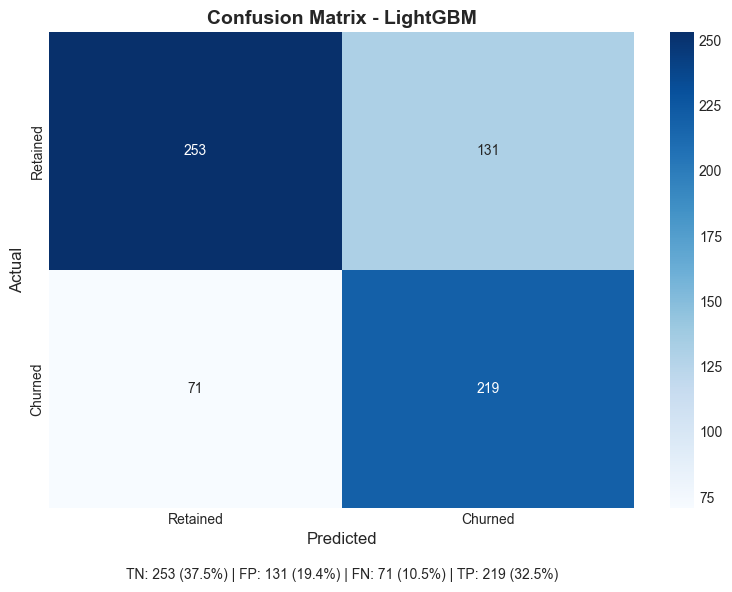

In [40]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_best)

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Retained', 'Churned'],
            yticklabels=['Retained', 'Churned'], ax=ax)
ax.set_xlabel('Predicted', fontsize=12)
ax.set_ylabel('Actual', fontsize=12)
ax.set_title(f'Confusion Matrix - {best_model_name}', fontsize=14, fontweight='bold')

# Add percentages
tn, fp, fn, tp = cm.ravel()
total = tn + fp + fn + tp
ax.text(0.5, -0.15, f'TN: {tn} ({tn/total*100:.1f}%) | FP: {fp} ({fp/total*100:.1f}%) | FN: {fn} ({fn/total*100:.1f}%) | TP: {tp} ({tp/total*100:.1f}%)',
        transform=ax.transAxes, ha='center', fontsize=10)

plt.tight_layout()
plt.savefig('../docs/figures/confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

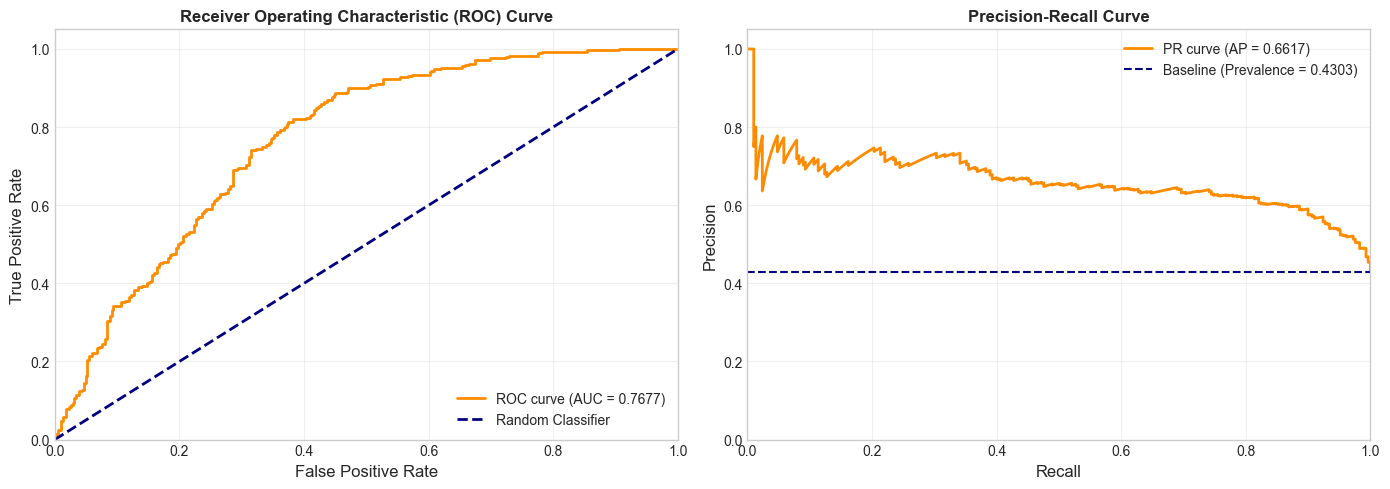

In [41]:
# ROC and PR curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ROC Curve
fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_proba_best)
roc_auc = roc_auc_score(y_test, y_pred_proba_best)

axes[0].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate', fontsize=12)
axes[0].set_ylabel('True Positive Rate', fontsize=12)
axes[0].set_title('Receiver Operating Characteristic (ROC) Curve', fontsize=12, fontweight='bold')
axes[0].legend(loc='lower right')
axes[0].grid(True, alpha=0.3)

# Precision-Recall Curve
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_pred_proba_best)
avg_precision = average_precision_score(y_test, y_pred_proba_best)

axes[1].plot(recall, precision, color='darkorange', lw=2, label=f'PR curve (AP = {avg_precision:.4f})')
axes[1].axhline(y=y_test.mean(), color='navy', linestyle='--', label=f'Baseline (Prevalence = {y_test.mean():.4f})')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('Recall', fontsize=12)
axes[1].set_ylabel('Precision', fontsize=12)
axes[1].set_title('Precision-Recall Curve', fontsize=12, fontweight='bold')
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../docs/figures/roc_pr_curves.png', dpi=150, bbox_inches='tight')
plt.show()

### 9.2 Feature Importance

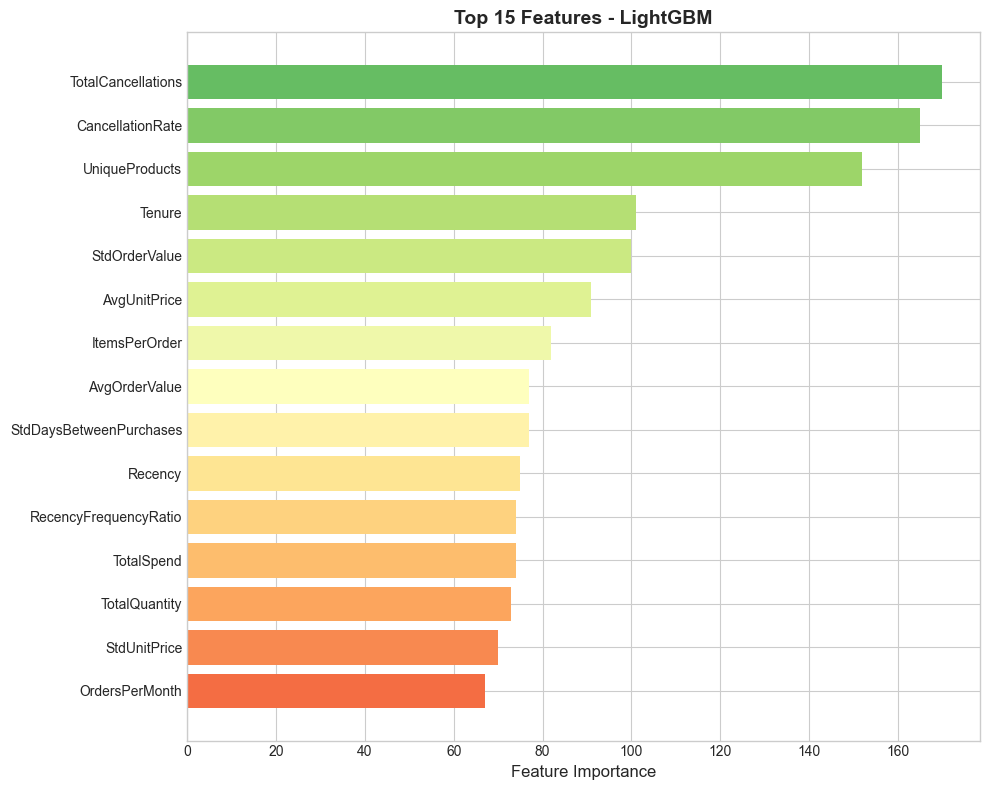


Top 10 Most Important Features:
                Feature  Importance
     TotalCancellations         170
       CancellationRate         165
         UniqueProducts         152
                 Tenure         101
          StdOrderValue         100
           AvgUnitPrice          91
          ItemsPerOrder          82
          AvgOrderValue          77
StdDaysBetweenPurchases          77
                Recency          75


In [42]:
# Feature importance from best model
if hasattr(best_model, 'feature_importances_'):
    importance = best_model.feature_importances_
else:
    importance = np.abs(best_model.coef_[0])

feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': importance
}).sort_values('Importance', ascending=False)

# Plot top 15 features
fig, ax = plt.subplots(figsize=(10, 8))

top_features = feature_importance.head(15)
colors = plt.cm.RdYlGn(np.linspace(0.2, 0.8, len(top_features)))

bars = ax.barh(top_features['Feature'], top_features['Importance'], color=colors[::-1])
ax.set_xlabel('Feature Importance', fontsize=12)
ax.set_title(f'Top 15 Features - {best_model_name}', fontsize=14, fontweight='bold')
ax.invert_yaxis()

plt.tight_layout()
plt.savefig('../docs/figures/feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10).to_string(index=False))

## 10. Model Interpretation with SHAP

In [43]:
# SHAP analysis
print("Calculating SHAP values (this may take a minute)...")

# Use a sample for SHAP to speed up computation
sample_size = min(500, len(X_test_scaled))
X_sample = X_test_scaled.sample(n=sample_size, random_state=42)

# Create explainer based on model type
if best_model_name in ['Random Forest', 'Gradient Boosting', 'XGBoost', 'LightGBM', 'Decision Tree']:
    explainer = shap.TreeExplainer(best_model)
else:
    explainer = shap.LinearExplainer(best_model, X_train_scaled)

shap_values = explainer.shap_values(X_sample)

# Handle different SHAP output formats
if isinstance(shap_values, list):
    shap_values = shap_values[1]  # For binary classification, use class 1 (churned)

print("SHAP values calculated!")

Calculating SHAP values (this may take a minute)...
SHAP values calculated!


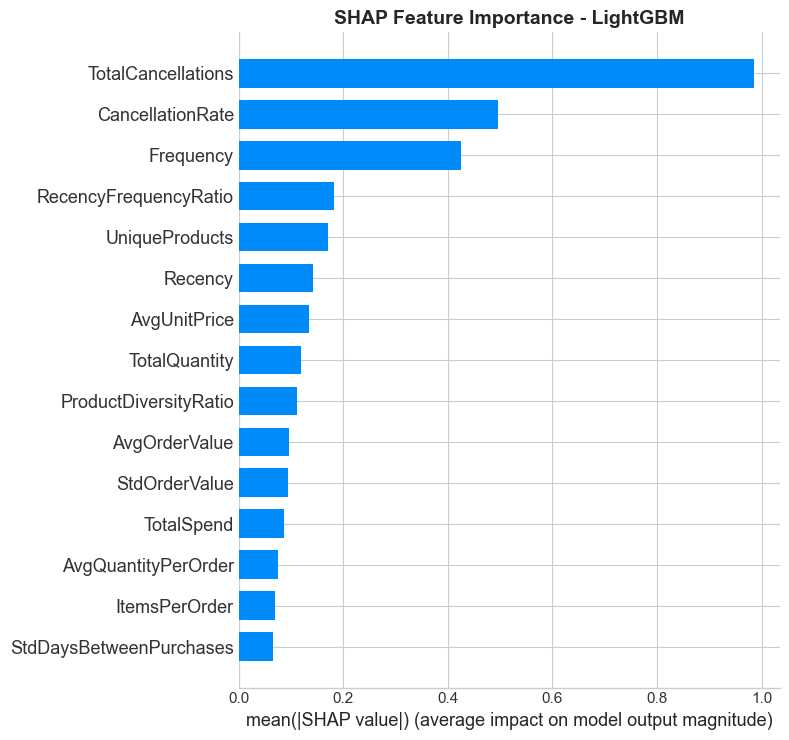

In [44]:
# SHAP Summary Plot (Bar)
fig, ax = plt.subplots(figsize=(10, 8))
shap.summary_plot(shap_values, X_sample, plot_type="bar", show=False, max_display=15)
plt.title(f'SHAP Feature Importance - {best_model_name}', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../docs/figures/shap_importance.png', dpi=150, bbox_inches='tight')
plt.show()

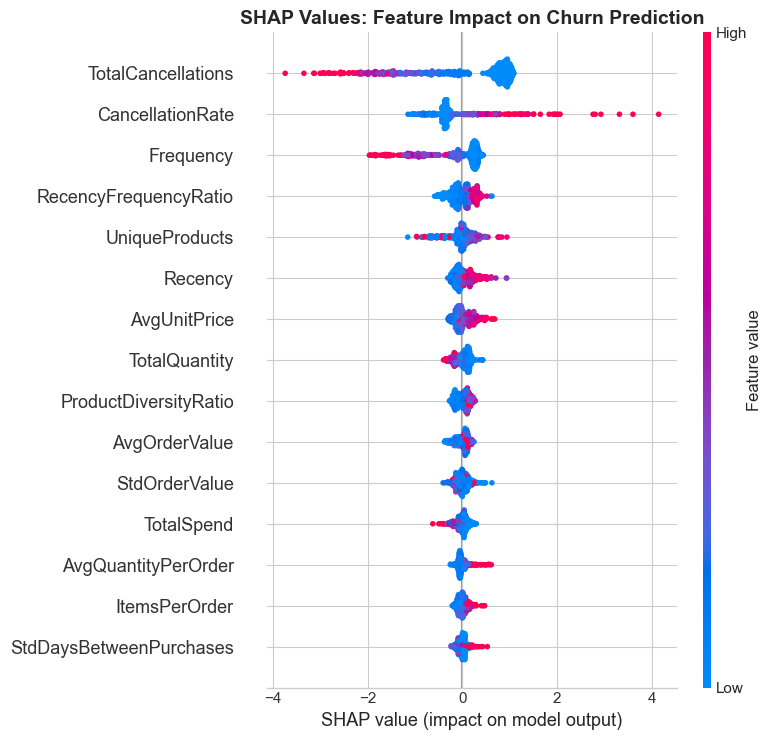

In [45]:
# SHAP Beeswarm Plot
fig, ax = plt.subplots(figsize=(10, 8))
shap.summary_plot(shap_values, X_sample, show=False, max_display=15)
plt.title(f'SHAP Values: Feature Impact on Churn Prediction', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../docs/figures/shap_beeswarm.png', dpi=150, bbox_inches='tight')
plt.show()

## 11. Business Recommendations

In [46]:
# Identify high-risk customers
test_customers = df_final.loc[X_test.index, ['CustomerID', 'Churned']].copy()
test_customers['ChurnProbability'] = y_pred_proba_best
test_customers['RiskCategory'] = pd.cut(
    test_customers['ChurnProbability'],
    bins=[0, 0.3, 0.6, 1.0],
    labels=['Low Risk', 'Medium Risk', 'High Risk']
)

print("Customer Risk Segmentation:")
print(test_customers['RiskCategory'].value_counts().to_string())
print(f"\nActual churn rate by risk category:")
print(test_customers.groupby('RiskCategory')['Churned'].mean().round(3).to_string())

Customer Risk Segmentation:
RiskCategory
High Risk      274
Low Risk       233
Medium Risk    167

Actual churn rate by risk category:
RiskCategory
Low Risk      0.13
Medium Risk   0.50
High Risk     0.64


In [47]:
# Key churn indicators summary
print("\n" + "="*70)
print("KEY CHURN INDICATORS - BUSINESS RECOMMENDATIONS")
print("="*70)

print("\n📊 TOP PREDICTORS OF CHURN:")
for i, row in feature_importance.head(5).iterrows():
    print(f"  • {row['Feature']}: {row['Importance']:.4f}")

print("\n🎯 RETENTION STRATEGIES:")
print("  1. RECENCY-BASED TRIGGERS: Set up automated emails when customers")
print("     haven't purchased in 30+ days")
print("  2. FREQUENCY INCENTIVES: Reward programs for repeat purchases")
print("  3. RE-ENGAGEMENT CAMPAIGNS: Target medium-risk customers with")
print("     personalized offers")
print("  4. PRODUCT RECOMMENDATIONS: Increase product diversity for")
print("     single-category shoppers")

print("\n📈 MONITORING METRICS:")
print(f"  • Model ROC-AUC: {roc_auc:.4f}")
print(f"  • Precision (Churn): {precision_score(y_test, y_pred_best):.4f}")
print(f"  • Recall (Churn): {recall_score(y_test, y_pred_best):.4f}")
print(f"  • High-Risk Customers: {(test_customers['RiskCategory'] == 'High Risk').sum()}")


KEY CHURN INDICATORS - BUSINESS RECOMMENDATIONS

📊 TOP PREDICTORS OF CHURN:
  • TotalCancellations: 170.0000
  • CancellationRate: 165.0000
  • UniqueProducts: 152.0000
  • Tenure: 101.0000
  • StdOrderValue: 100.0000

🎯 RETENTION STRATEGIES:
  1. RECENCY-BASED TRIGGERS: Set up automated emails when customers
     haven't purchased in 30+ days
  2. FREQUENCY INCENTIVES: Reward programs for repeat purchases
  3. RE-ENGAGEMENT CAMPAIGNS: Target medium-risk customers with
     personalized offers
  4. PRODUCT RECOMMENDATIONS: Increase product diversity for
     single-category shoppers

📈 MONITORING METRICS:
  • Model ROC-AUC: 0.7677
  • Precision (Churn): 0.6257
  • Recall (Churn): 0.7552
  • High-Risk Customers: 274


## 12. Conclusions

In [48]:
# Save model and artifacts
joblib.dump(best_model, '../models/churn_model.joblib')
joblib.dump(scaler, '../models/scaler.joblib')

print("Model saved: ../models/churn_model.joblib")
print("Scaler saved: ../models/scaler.joblib")

Model saved: ../models/churn_model.joblib
Scaler saved: ../models/scaler.joblib


In [49]:
# Save processed data
df_final.to_csv('../data/processed/customer_features.csv', index=False)
print("Processed data saved: ../data/processed/customer_features.csv")

Processed data saved: ../data/processed/customer_features.csv


In [50]:
# Final summary
print("\n" + "="*70)
print("PROJECT SUMMARY")
print("="*70)

print(f"\n📊 DATASET:")
print(f"  • Original transactions: {len(df):,}")
print(f"  • Customers analyzed: {len(df_final):,}")
print(f"  • Features engineered: {len(feature_cols)}")
print(f"  • Churn rate: {df_final['Churned'].mean()*100:.1f}%")

print(f"\n🤖 BEST MODEL: {best_model_name}")
print(f"  • Test ROC-AUC: {roc_auc:.4f}")
print(f"  • Test Accuracy: {accuracy_score(y_test, y_pred_best):.4f}")
print(f"  • Test F1 Score: {f1_score(y_test, y_pred_best):.4f}")
print(f"  • Test Precision: {precision_score(y_test, y_pred_best):.4f}")
print(f"  • Test Recall: {recall_score(y_test, y_pred_best):.4f}")

print(f"\n🔑 TOP PREDICTIVE FEATURES:")
for i, (_, row) in enumerate(feature_importance.head(5).iterrows(), 1):
    print(f"  {i}. {row['Feature']}")

print("\n" + "="*70)


PROJECT SUMMARY

📊 DATASET:
  • Original transactions: 541,909
  • Customers analyzed: 3,370
  • Features engineered: 24
  • Churn rate: 43.0%

🤖 BEST MODEL: LightGBM
  • Test ROC-AUC: 0.7677
  • Test Accuracy: 0.7003
  • Test F1 Score: 0.6844
  • Test Precision: 0.6257
  • Test Recall: 0.7552

🔑 TOP PREDICTIVE FEATURES:
  1. TotalCancellations
  2. CancellationRate
  3. UniqueProducts
  4. Tenure
  5. StdOrderValue

